In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import jit
import model
import importlib
model = importlib.reload(model)
from common import constraints, cosmology

In [2]:
@jit(nopython=True)
def pot(theta, f_a, T, params):
    m, g = params
    return 0.5 * m**2 * f_a**2 * theta**2 + g * (f_a * theta)**4

@jit(nopython=True)
def pot_deriv(theta, f_a, T, params):
    m, g = params
    return m**2 * theta + g * f_a**2 * theta**3

model.add_pot("with_self_coupling", pot, pot_deriv)

f_a = 3e14
H_inf = 2e10

In [3]:
def calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, num_osc):
    to_osc = lambda E: 1/(2*E) if Gamma_phi >= m_a else 2/(3*E)
    axion_period = lambda E: 2*np.pi/E
    t_osc_m = to_osc(m_a)
    E_g = np.sqrt(g) * f_a
    t_osc_g = to_osc(E_g)
    t_start = 1 / H_inf
    def end_time(E):
        t_end = to_osc(E) + axion_period(E) * num_osc
        if t_end < t_start:
            return t_start * 10
        else:
            return t_end
    if t_osc_m < t_osc_g:
        return end_time(E_g)
    else:
        return end_time(m_a)
    
def calc_axion_periode(g, m_a, f_a, Gamma_phi):
    E_g = np.sqrt(g) * f_a
    if E_g > m_a:
        return 2*np.pi / E_g
    else:
        return 2*np.pi / m_a

In [61]:
Gamma_phi = 1e8
m_a = 1 
f_a = 2e10
H_inf = constraints.calc_H_inf_max(f_a)
g_range = np.geomspace(1e-6, 1e1, 20)
f_a_range = np.geomspace(1e9, 1e11, 10)
n = 15

In [62]:
eta_B_s = np.array([[model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf, "with_self_coupling", (m_a, g),
                    bg_kwargs=dict(end=calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, n), 
                                   inc=calc_axion_periode(g, m_a, f_a, Gamma_phi) * n)) 
                     for g in g_range] for f_a in tqdm(f_a_range)])

KeyboardInterrupt: 

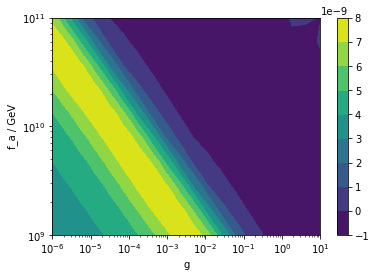

In [60]:
plt.contourf(g_range, f_a_range, eta_B_s, )
plt.xscale("log"); plt.yscale("log")
plt.xlabel("g")
plt.ylabel("f_a / GeV")
plt.colorbar()

In [25]:
g = 1e-3
sol = model.simulate(f_a=f_a, Gamma_phi=Gamma_phi, H_inf=H_inf, pot_name="with_self_coupling", params=(m_a, g),
              end=calc_end_time(g, m_a, f_a, Gamma_phi, H_inf, n), 
              inc=calc_axion_periode(g, m_a, f_a, Gamma_phi) * n)

In [26]:
g = 0
sol_h = model.simulate(f_a=f_a, Gamma_phi=Gamma_phi, H_inf=H_inf, pot_name="with_self_coupling", params=(m_a, g),
              end=(1/(2*m_a) if Gamma_phi >= m_a else 2/(3*m_a)), 
              inc=2*np.pi / m_a * n)

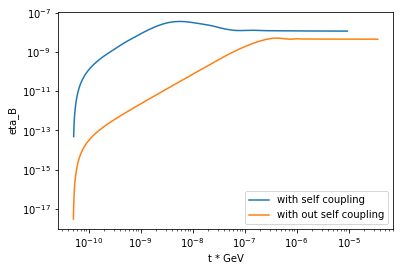

In [27]:
plt.loglog(sol.t, cosmology.n_L_to_eta_B_final(sol.T, sol.n_L), label="with self coupling")
plt.loglog(sol_h.t, cosmology.n_L_to_eta_B_final(sol_h.T, sol_h.n_L), label="with out self coupling")
plt.xlabel("t * GeV")
plt.ylabel("eta_B")
plt.legend();